# ASCAT obs_var diagnostics (Err_6.4%, Err_9.0%, CNTL)

Adapts the CYGNSS DA figure notebook to the three ASCAT obs-var experiments:
- Err_6.4%: `LS_DAv8_M36_obs_var_64_*`
- Err_9.0%: `LS_DAv8_M36_obs_var_9_*`
- CNTL: `LS_OLv8_M36_*`


In [1]:
import numpy as np
import pickle
from datetime import datetime
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Repo helpers

def find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / '.git').exists():
            return p
    return start

here = Path(__file__).resolve().parent if '__file__' in globals() else Path.cwd()
repo_root = find_repo_root(here)
sys.path.append(str(repo_root / 'common' / 'python' / 'io'))
sys.path.append(str(repo_root / 'common' / 'python' / 'plotting'))
sys.path.append(str(repo_root / 'projects' / 'matlab2python' / 'shared' / 'python'))

from read_GEOSldas import read_tilecoord
from geospatial_plotting import load_ease_grid, build_ease_grid_mapping, REGION_BOUNDS


In [2]:
# File locations
DATA_DIR = Path('/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/ASCAT_obs_var')

experiments = {
    '   ': {
        'label': 'CNTL',
        'temporal': DATA_DIR / 'temporal_stats_OL_9_20150401_20200331.nc4',
        'spatial': DATA_DIR / 'spatial_stats_OL_9_201504_202003.pkl',
    },
    'Err_9.0%': {
        'label': 'Err_9.0%',
        'temporal': DATA_DIR / 'temporal_stats_DA_9_20150401_20200331.nc4',
        'spatial': DATA_DIR / 'spatial_stats_DA_9_201504_202003.pkl',
    },
    'Err_6.4%': {
        'label': 'Err_6.4%',
        'temporal': DATA_DIR / 'temporal_stats_DA_64_20150401_20200331.nc4',
        'spatial': DATA_DIR / 'spatial_stats_DA_64_201504_202003.pkl',
    },
}

tilecoord_bin = DATA_DIR / 'LS_DAv8_M36_obs_var_9.ldas_tilecoord.bin'  # grid is shared across experiments
NMIN = 20


In [3]:
# Species groupings (same indexing as CYGNSS diagnostics)
species_groups = {
    'ASCAT': [8, 9, 10],
    'SMAP': [4, 5, 6, 7],
    'SMOS': [0, 1, 2, 3]
}

In [4]:
def read_nc_stats(path: Path):
    stats = {}
    with Dataset(path, 'r') as nc:
        for key, var in nc.variables.items():
            arr = var[:].filled(np.nan)
            stats[key] = arr
    return stats

stats_temporal = {name: read_nc_stats(cfg['temporal']) for name, cfg in experiments.items()}


In [5]:
def read_spatial(path: Path):
    with open(path, 'rb') as f:
        return pickle.load(f)

stats_spatial = {name: read_spatial(cfg['spatial']) for name, cfg in experiments.items()}


In [6]:
def compute_group_metrics(stats_dict, species_groups, nmin=NMIN):
    # Copy arrays to avoid side-effects
    N_data = stats_dict['N_data'].astype(float)
    OmF_mean = stats_dict['OmF_mean'].astype(float)
    OmF_stdv = stats_dict['OmF_stdv'].astype(float)
    OmF_norm_mean = stats_dict['OmF_norm_mean'].astype(float)
    OmF_norm_stdv = stats_dict['OmF_norm_stdv'].astype(float)
    OmA_mean = stats_dict['OmA_mean'].astype(float)
    OmA_stdv = stats_dict['OmA_stdv'].astype(float)

    # Mask insufficient obs
    mask = N_data < nmin
    for arr in [OmF_mean, OmF_stdv, OmF_norm_mean, OmF_norm_stdv, OmA_mean, OmA_stdv]:
        arr[mask] = np.nan
    N_data_masked = N_data.copy()
    N_data_masked[mask] = 0

    group_metrics = {}
    for group, idx in species_groups.items():
        gN = np.nansum(N_data_masked[:, idx], axis=1)
        def wavg(arr):
            return np.nansum(arr[:, idx] * N_data_masked[:, idx], axis=1) / gN
        group_metrics[group] = {
            'OmF_mean': wavg(OmF_mean),
            'OmF_stdv': wavg(OmF_stdv),
            'OmF_norm_mean': wavg(OmF_norm_mean),
            'OmF_norm_stdv': wavg(OmF_norm_stdv),
            'OmA_mean': wavg(OmA_mean),
            'OmA_stdv': wavg(OmA_stdv),
            'Nobs_data': gN,
        }
    return group_metrics

per_group = {name: compute_group_metrics(stats, species_groups) for name, stats in stats_temporal.items()}


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52726/656179270.py:22: RuntimeWarning: invalid value encountered in divide
  return np.nansum(arr[:, idx] * N_data_masked[:, idx], axis=1) / gN


In [7]:
def convert_stats_dict_to_arrays(stats_dict):
    arrs = {}
    for key, val in stats_dict.items():
        arr = np.array(val)
        if arr.dtype.kind in {'U', 'S', 'O'}:
            cleaned = []
            for row in arr:
                cleaned.append([np.nan if x == '--' else float(x) for x in row])
            arr = np.array(cleaned)
        arrs[key] = arr
    return arrs

spatial_arrays = {name: convert_stats_dict_to_arrays(d) for name, d in stats_spatial.items()}

def parse_dates(date_vec):
    return [datetime.strptime(s, '%Y%m') for s in date_vec]

date_vecs = {name: parse_dates(d['date_vec']) for name, d in stats_spatial.items() if 'date_vec' in d}


In [8]:
def calculate_weighted_group_stats(stats_dict, species_groups):
    n_times = len(stats_dict['OmF_mean'])
    stats = ['O_mean','F_mean','OmF_mean','OmF_stdv','OmA_mean','OmA_stdv']
    out = {g: {stat: np.full(n_times, np.nan) for stat in stats} for g in species_groups}
    for g in species_groups:
        out[g]['N_data'] = np.zeros(n_times)
    for t in range(n_times):
        for g, idx in species_groups.items():
            w = stats_dict['N_data'][t, idx]
            tot = np.sum(w)
            if tot == 0:
                continue
            for stat in stats:
                vals = stats_dict[stat][t, idx]
                out[g][stat][t] = np.average(vals, weights=w)
            out[g]['N_data'][t] = tot
    return out

group_ts = {name: calculate_weighted_group_stats(arrs, species_groups) for name, arrs in spatial_arrays.items()}


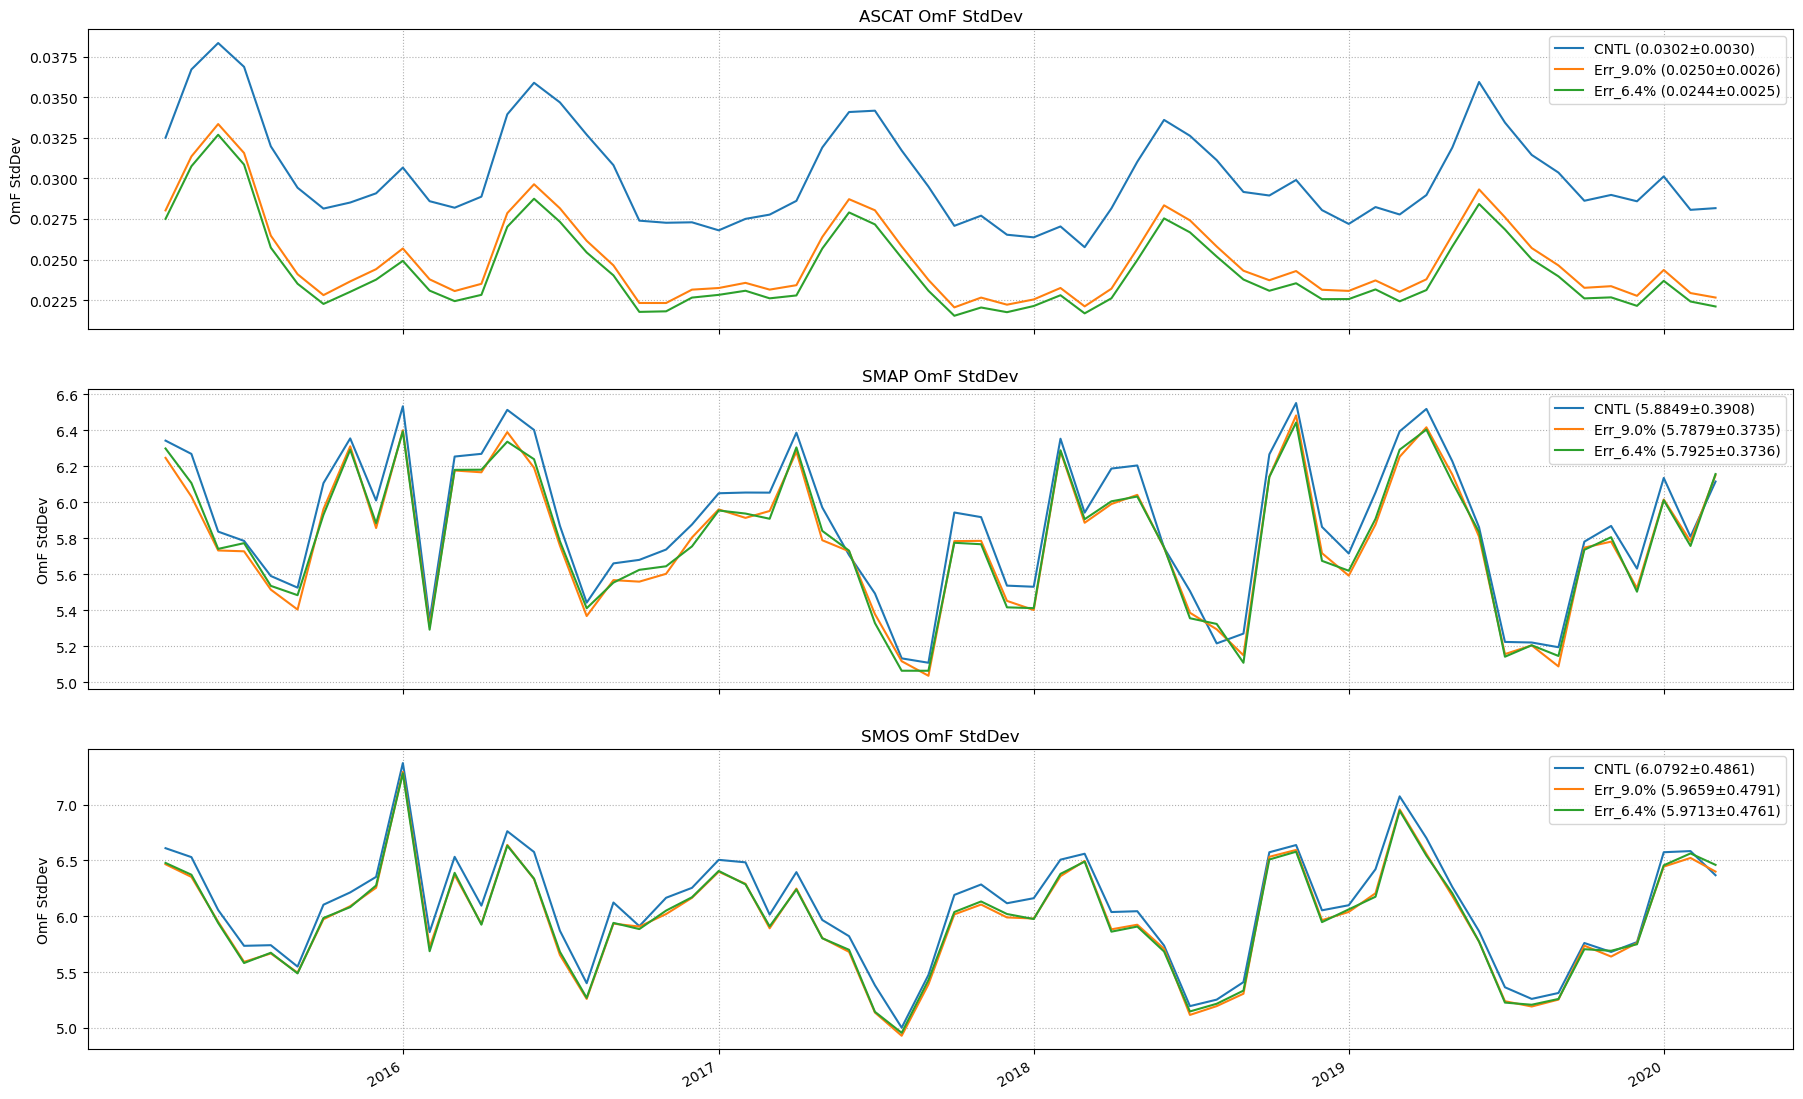

In [20]:
# Time series: OmF stddev per group across experiments
fig, axes = plt.subplots(3,1, figsize=(22,15), sharex=True)
axes = axes.flatten()
for ax, group in zip(axes, ['ASCAT','SMAP','SMOS']):
    for name, ts in group_ts.items():
        dates = date_vecs.get(name)
        if dates is None:
            continue
        data = ts[group]['OmF_stdv']
        mean_val = np.nanmean(data)
        std_val = np.nanstd(data)
        label = f"{experiments[name]['label']} ({mean_val:.4f}±{std_val:.4f})"
        ax.plot(dates, data, label=label)
    ax.set_title(f"{group} OmF StdDev")
    ax.grid(True, linestyle=':')
    ax.legend()
    ax.set_ylabel('OmF StdDev')
fig.autofmt_xdate()
plt.show()

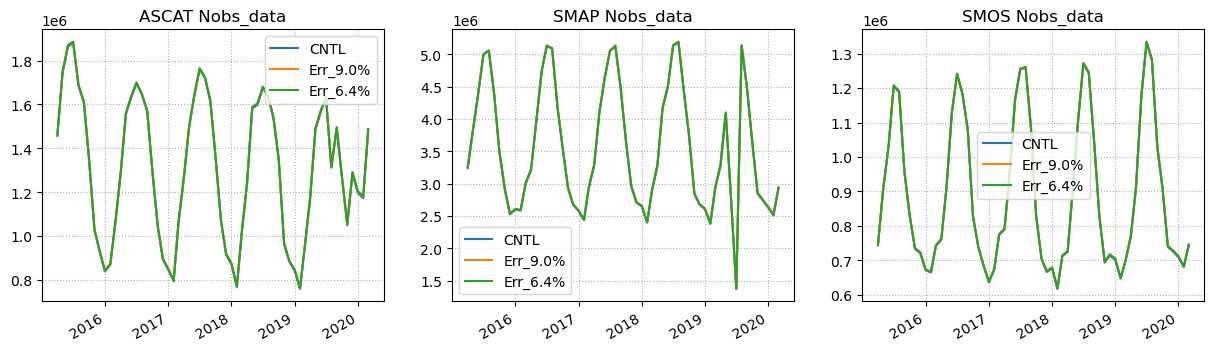

In [10]:
# Time series: OmF stddev per group across experiments
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True)
axes = axes.flatten()
for ax, group in zip(axes, ['ASCAT','SMAP','SMOS']):
    for name, ts in group_ts.items():
        dates = date_vecs.get(name)
        if dates is None:
            continue
        ax.plot(dates, ts[group]['N_data'], label=experiments[name]['label'])
    ax.set_title(f"{group} Nobs_data")
    ax.grid(True, linestyle=':')
    ax.legend()
fig.autofmt_xdate()
plt.show()

In [11]:
# Tile coordinate info for mapping
tc = read_tilecoord(tilecoord_bin)
n_tile = tc['N_tile']
lat = tc['com_lat']
lon = tc['com_lon']
map_array = np.empty([n_tile, 3]); map_array.fill(np.nan)
map_array[:,1] = lon
map_array[:,2] = lat
lats, lons = load_ease_grid()
lats_row, lons_col = lats[:,1], lons[1,:]
lon_grid, lat_grid = np.meshgrid(lons_col, lats_row)


reading from /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/ASCAT_obs_var/LS_DAv8_M36_obs_var_9.ldas_tilecoord.bin
done reading file


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52726/1688676040.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis', len(edges)-1)
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52726/1688676040.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis', len(edges)-1)
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52726/1688676040.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

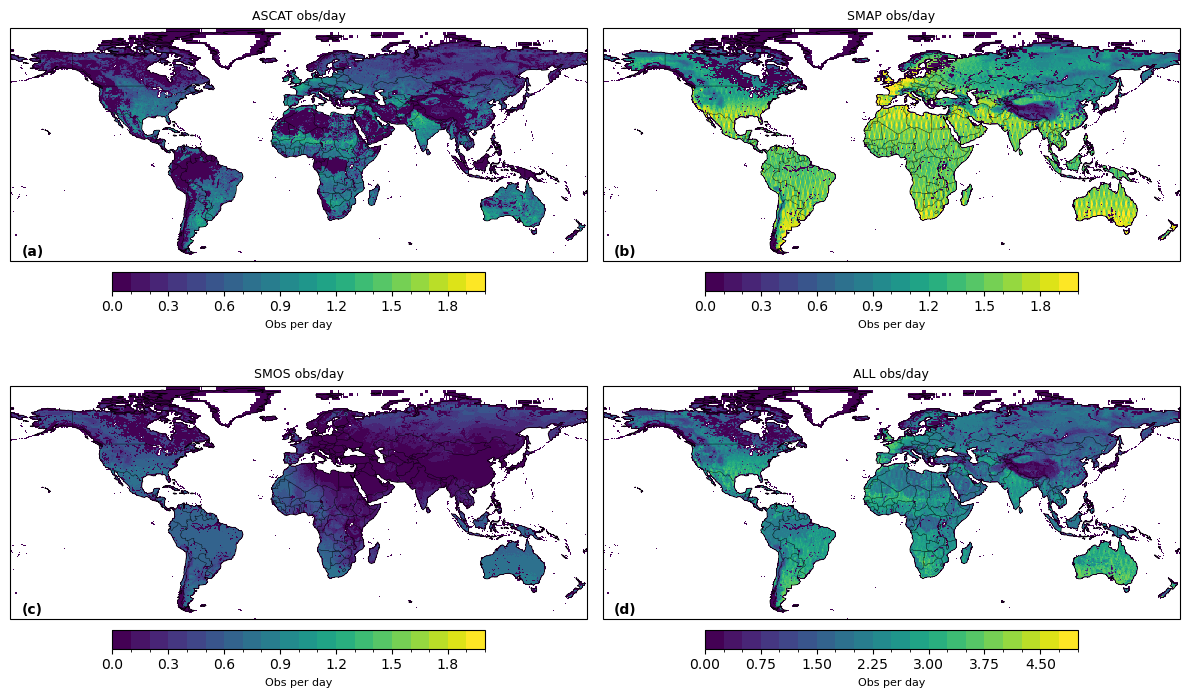

In [12]:
# Obs/day maps for Err_9.0%
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import get_cmap
import cartopy.crs as ccrs
import cartopy.feature as cfeature

ndays = (datetime(2020,3,31) - datetime(2015,4,1)).days + 1
per_day_maps = {g: np.nan_to_num(per_group['Err_9.0%'][g]['Nobs_data'] / ndays, nan=0.0) for g in species_groups}
total_obs_per_day = sum(per_day_maps.values())

panels = [
    ('ASCAT',  per_day_maps['ASCAT'],  'ASCAT obs/day',  (0, 2.0), '(a)'),
    ('SMAP',   per_day_maps['SMAP'],   'SMAP obs/day',   (0, 2.0), '(b)'),
    ('SMOS',   per_day_maps['SMOS'],   'SMOS obs/day',   (0, 2.0), '(c)'),
    ('ALL',    total_obs_per_day,      'ALL obs/day',    (0, 5.0), '(d)'),
]

fig, axes = plt.subplots(2, 2, figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()
for ax, (name, data_1d, title, clim, lab) in zip(axes, panels):
    map_array[:,0] = data_1d
    grid = build_ease_grid_mapping(map_array, lats_row, lons_col)
    edges = np.linspace(clim[0], clim[1], 21)
    cmap = get_cmap('viridis', len(edges)-1)
    norm = BoundaryNorm(edges, cmap.N)
    sc = ax.pcolormesh(lon_grid, lat_grid, grid, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.set_extent(REGION_BOUNDS['global'], crs=ccrs.PlateCarree())
    ax.set_title(title, fontsize=9)
    ax.text(0.02, 0.02, lab, transform=ax.transAxes, fontsize=10, fontweight='bold')
    cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.03, fraction=0.05)
    cbar.set_label('Obs per day', fontsize=8)
plt.tight_layout()
plt.show()


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52726/3854266435.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=(0, 0.07, 1, 1))


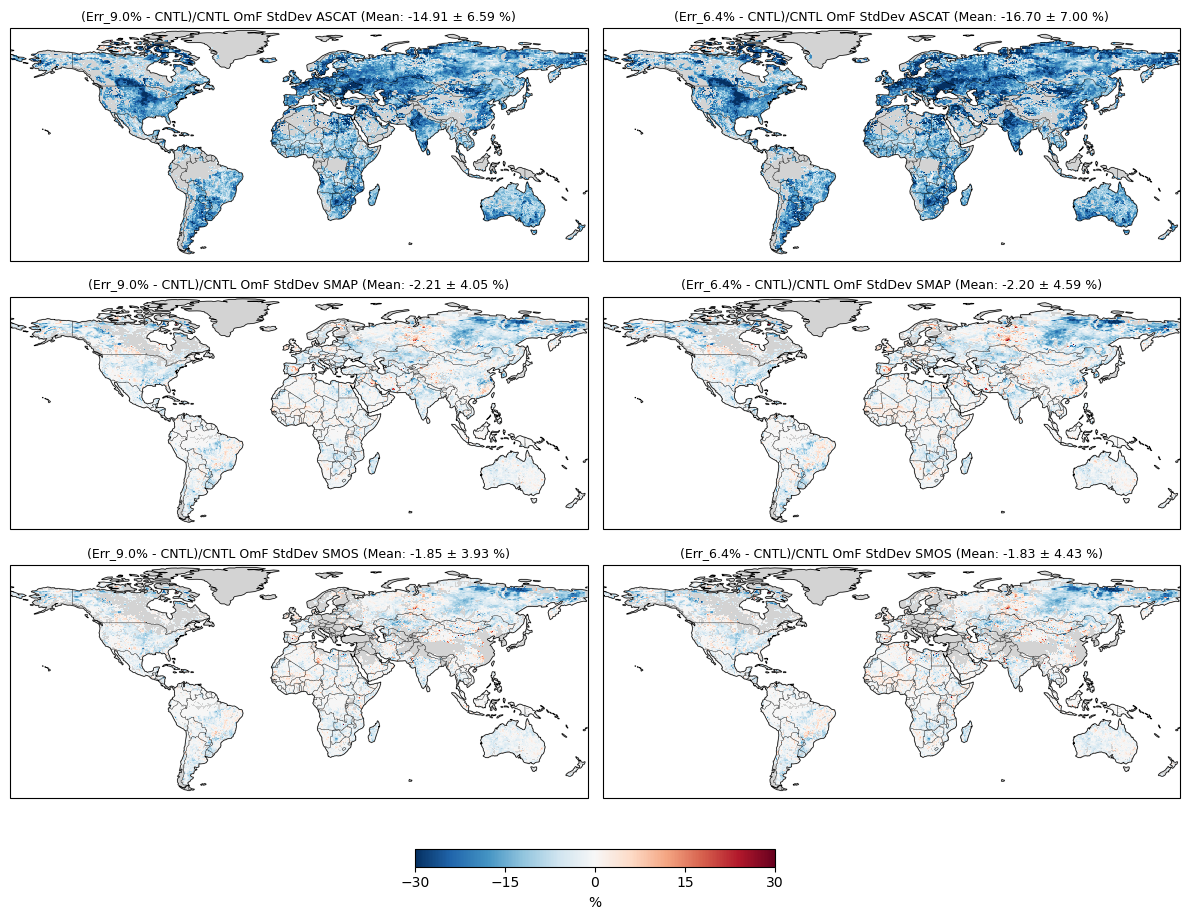

In [13]:
# Percent-difference maps for OmF StdDev: Err_9.0% vs CNTL and Err_6.4% vs CNTL
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Determine which key corresponds to the control run
control_key = next((k for k, cfg in experiments.items() if cfg.get('label') == 'CNTL'), 'CNTL')

def pct_diff(da, ol):
    return np.divide(da - ol, ol, out=np.full_like(ol, np.nan, dtype=float), where=ol != 0) * 100.0

# Left column: 9%; Right column: 6.4%; rows: ASCAT, SMAP, SMOS
pairs = [
    ('ASCAT', 'Err_9.0%'),
    ('ASCAT', 'Err_6.4%'),
    ('SMAP',  'Err_9.0%'),
    ('SMAP',  'Err_6.4%'),
    ('SMOS',  'Err_9.0%'),
    ('SMOS',  'Err_6.4%'),
]
vmin, vmax = -30.0, 30.0

fig, axes = plt.subplots(3, 2, figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()
for ax, (species, exp) in zip(axes, pairs):
    da = per_group[exp][species]['OmF_stdv']
    ol = per_group[control_key][species]['OmF_stdv']
    data_1d = pct_diff(da, ol)
    mean_val = np.nanmean(data_1d)
    std_val = np.nanstd(data_1d)
    map_array[:,0] = data_1d
    grid = build_ease_grid_mapping(map_array, lats_row, lons_col)
    sc = ax.pcolormesh(lon_grid, lat_grid, grid, cmap='RdBu_r', vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.LAND, color='lightgray', zorder=0)
    ax.set_extent(REGION_BOUNDS['global'], crs=ccrs.PlateCarree())
    ax.set_title(f'({exp} - CNTL)/CNTL OmF StdDev {species} (Mean: {mean_val:.2f} ± {std_val:.2f} %)', fontsize=9)
    ax.tick_params(labelbottom=False, labelleft=False)

cax = fig.add_axes([0.35, 0.03, 0.30, 0.02])
cbar = fig.colorbar(sc, cax=cax, orientation='horizontal')
cbar.set_label('%', fontsize=10)
cbar.set_ticks([-30, -15, 0, 15, 30])
fig.tight_layout(rect=(0, 0.07, 1, 1))
plt.show()
